In [28]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 1000

In [2]:
csv_save_dir = 'output_csvs_NEW_AUG_2018_Corrected_for_Curated_Relations'
if not os.path.exists(csv_save_dir):
    os.makedirs(csv_save_dir)

In [3]:
%%time

# Read information for the new records
records = pd.read_csv('new-citations-NEWAUG2018-corrected_for_curated-references.tsv', sep='\t')
records.columns = ['index_to_drop', 'recID', 'oldRef', 'newRef', 'metaData']
records = records.drop('index_to_drop', axis=1)

print('Total Records: {}'.format(len(records)))

Total Records: 31175879
CPU times: user 3min 11s, sys: 12.1 s, total: 3min 23s
Wall time: 3min 29s


In [10]:
# Read the new citation counts
labs = pd.read_csv('new-citation-counts-NEWAUG2018-corrected_for_curated_references.tsv', sep='\t', header=None)
labs.columns = ['recID', 'Citation_Difference']
# Citation_Difference is actually citation count but is used here for ease later when subtracting

# Index by recIDs
labs_indexed = labs.set_index('recID')

In [12]:
# Read the legacy citation counts
legacy = pd.read_csv('old-citation-counts-AUG2018.csv', sep=',')
legacy.columns = ['recID', 'Citation_Difference', 'Timestamp']
# Citation_Difference is actually citation count but is used here for ease later when subtracting
legacy = legacy.drop(['Timestamp'], axis='columns')

# Index by recrod IDs
legacy_indexed = legacy.set_index('recID')

In [14]:
# Compute the difference in citation counts between Labs and Legacy
diff = labs_indexed - legacy_indexed

In [15]:
# Filter out the NaNs
is_nan = diff.Citation_Difference.isna()
NaN_entries = diff[is_nan]

print('{} articles are differently indexed between the legacy and labs records and have no correspondence'.format(len(NaN_entries)))

6799 articles are differently indexed between the legacy and labs records and have no correspondence


In [16]:
# Filter the valid entries
is_valid = ~diff.Citation_Difference.isna()
valid_diff = diff[is_valid]

In [17]:
# Get the articles which have lost citations
lost = valid_diff.Citation_Difference < 0
lost_citations = valid_diff[lost]

# Sort the list
lost_citations = lost_citations.sort_values('Citation_Difference')

In [18]:
# Get the articles which have gained citations
gained = valid_diff.Citation_Difference > 0
gained_citations = valid_diff[gained]

# Sort the list
gained_citations = gained_citations.sort_values('Citation_Difference', ascending=False)

In [19]:
# Get the counts for absolute differences in citation numbers
abs_diff = np.abs(valid_diff)
abs_diff = abs_diff.sort_values('Citation_Difference', ascending=False)

# Get just the zero difference entries
zero_diff = abs_diff.Citation_Difference == 0
zero_diff = abs_diff[zero_diff]

# Filter out the zero difference entries
non_zero_diff = abs_diff.Citation_Difference != 0
abs_diff = abs_diff[non_zero_diff]

In [20]:
# Initialize extended DataFrames for the differences
lost_citations_ext = lost_citations
gained_citations_ext = gained_citations
abs_diff_ext = abs_diff

# For lost citations
lost_citations_ext['Legacy_Count'] = legacy_indexed.loc[lost_citations.index]
lost_citations_ext['Labs_Count'] = labs_indexed.loc[lost_citations.index]

# For gained citations
gained_citations_ext['Legacy_Count'] = legacy_indexed.loc[gained_citations.index]
gained_citations_ext['Labs_Count'] = labs_indexed.loc[gained_citations.index]

# For absolute difference in citation counts
abs_diff_ext['Legacy_Count'] = legacy_indexed.loc[abs_diff.index]
abs_diff_ext['Labs_Count'] = labs_indexed.loc[abs_diff.index]

### Incorporate "invalid/NaN" entries

In [21]:
invalid_records = NaN_entries.index

In [22]:
legacy_NaNs = np.intersect1d(legacy_indexed.index, invalid_records)
legacy_only = legacy_indexed.loc[list(legacy_NaNs)]
len(legacy_only)

4445

In [23]:
labs_NaNs = np.intersect1d(labs_indexed.index, invalid_records)
labs_only = labs_indexed.loc[list(labs_NaNs)]
len(labs_only)

2354

In [24]:
# PLEASE RUN ONLY ONCE TO AVOID MULTIPLE APPENDS

# Initialize extended DataFrames for the "invalid" differences
legacy_only_ext = legacy_only
labs_only_ext = labs_only

# For legacy_only (Lost citations)
legacy_only_ext['Legacy_Count'] = legacy_only.Citation_Difference
legacy_only_ext['Labs_Count'] = 0


# For labs_only (Gained citations)
labs_only_ext['Legacy_Count'] = 0
labs_only_ext['Labs_Count'] = labs_only.Citation_Difference

# Append to the appropriate categories
abs_diff_ext = abs_diff_ext.append(legacy_only_ext)
abs_diff_ext = abs_diff_ext.append(labs_only_ext)
abs_diff_ext = abs_diff_ext.sort_values('Citation_Difference', ascending=False)

gained_citations_ext = gained_citations_ext.append(labs_only_ext)
gained_citations_ext = gained_citations_ext.sort_values('Citation_Difference', ascending=False)

legacy_only_ext.Citation_Difference = legacy_only_ext.Citation_Difference * -1
lost_citations_ext = lost_citations_ext.append(legacy_only_ext)
lost_citations_ext = lost_citations_ext.sort_values('Citation_Difference')

In [25]:
# Save the citation difference DataFrames to CSV Files
lost_citations_ext.to_csv(os.path.join(csv_save_dir, 'lost_citations_prev.csv'))
gained_citations_ext.to_csv(os.path.join(csv_save_dir, 'gained_citations_prev.csv'))
abs_diff_ext.to_csv(os.path.join(csv_save_dir, 'overall_difference_prev.csv'))

### Investigate records which were not imported

In [29]:
diff_recids = list(abs_diff_ext.index)
def check_if_record_exists(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    if json_data.get('status') == 404:
        return False
    else:
        return True

In [30]:
exist_list = []
not_exist_list = []
for recid in diff_recids:
    if check_if_record_exists(recid):
        exist_list.append(recid)
    else:
        not_exist_list.append(recid)

In [33]:
exist_list = np.array(exist_list)
not_exist_list = np.array(not_exist_list)

In [34]:
exist_list.tofile('exist_list.csv', sep='\n')
not_exist_list.tofile('not_exist_list.csv', sep='\n')

In [31]:
len(exist_list)

114105

In [32]:
len(not_exist_list)

156

#### Filter out records which were not imported

In [35]:
abs_diff_ext = abs_diff_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext.reindex(exist_list)
lost_citations_ext = lost_citations_ext[~lost_citations_ext.Citation_Difference.isna()]
gained_citations_ext = gained_citations_ext.reindex(exist_list)
gained_citations_ext = gained_citations_ext[~gained_citations_ext.Citation_Difference.isna()]

### Some useful statistics

In [36]:
# Indicate Number of articles with zero differences in citation counts
num_cited_legacy = len(legacy.index.unique())
num_cited_labs = len(labs.index.unique())
num_unique_articles = len(records.recID.unique())
total_unique_cited_articles = len(np.union1d(legacy_indexed.index, labs_indexed.index)) - len(not_exist_list)
print('Total number of unique Cited articles as per legacy: {}'.format(num_cited_legacy))
print('Total number of unique Cited articles as per Labs: {}'.format(num_cited_labs))
print('Union of the above two - Total unique cited articles: {}'.format(total_unique_cited_articles))
print('\nTotal Number of Unique Articles which cite other papers: {}\n'.format(num_unique_articles))

num_zero_diff = valid_diff.Citation_Difference.value_counts()[0]
percent_zero_diff = num_zero_diff / total_unique_cited_articles * 100
print('Number of Cited articles with zero difference: {}'.format(num_zero_diff))
print('Percentage of Cited articles with zero difference: {0:0.2f} %'.format(percent_zero_diff))

Total number of unique Cited articles as per legacy: 776108
Total number of unique Cited articles as per Labs: 774017
Union of the above two - Total unique cited articles: 778306

Total Number of Unique Articles which cite other papers: 964161

Number of Cited articles with zero difference: 664201
Percentage of Cited articles with zero difference: 85.34 %


In [37]:
# Percentage Differences for absolute differences
abs_diff_counts = abs_diff_ext.Citation_Difference.value_counts()
print('Total Number of article with changes in citation counts in Labs: {}'.format(len(abs_diff_ext)))

print('\nNumber of articles with changes in Citation Counts in Labs')
print(abs_diff_counts[:5])

print('\nPercent (%) of Citation Counts Difference in Labs')
print(abs_diff_counts[:5] / total_unique_cited_articles * 100)

num_grt5 = sum(abs_diff_counts[6:])
percent_grt5 = num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with difference greater than 5 - Percentage: {} %\n'.format(num_grt5, percent_grt5))

Total Number of article with changes in citation counts in Labs: 114105

Number of articles with changes in Citation Counts in Labs
1.0    82229
2.0    15676
3.0     5622
4.0     2820
5.0     1687
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Difference in Labs
1.0    10.565125
2.0     2.014118
3.0     0.722338
4.0     0.362325
5.0     0.216753
Name: Citation_Difference, dtype: float64

Total 6071 records with difference greater than 5 - Percentage: 0.78002739282493 %



In [38]:
# Percentage Differences for lost citations
lost_citations_count = lost_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with loss in citation counts in Labs: {}'.format(len(lost_citations_ext)))

print('\nNumber of articles losing Citation Counts in Labs')
print(lost_citations_count[:-5])

lost_percent_diff = lost_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Lost in Labs')
print(lost_percent_diff[:-5])

lost_grt5 = sum(lost_citations_count[-6:])
lost_percent_grt5 = lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with lost citations greater than 5 - Percentage: {} %\n'.format(lost_grt5, lost_percent_grt5))

Total Number of article with loss in citation counts in Labs: 39452

Number of articles losing Citation Counts in Labs
-1.0    30592
-2.0     4125
-3.0     1350
-4.0      682
-5.0      437
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Lost in Labs
-1.0    3.930588
-2.0    0.529997
-3.0    0.173454
-4.0    0.087626
-5.0    0.056148
Name: Citation_Difference, dtype: float64

Total 2266 records with lost citations greater than 5 - Percentage: 0.29114512800877806 %



In [39]:
# Percentage Differences for gained citations
gained_citations_count = gained_citations_ext.Citation_Difference.value_counts()
print('Total Number of article with gain in citation counts in Labs: {}'.format(len(gained_citations_ext)))

print('\nNumber of articles gaining Citation Counts in Labs')
print(gained_citations_count[:5])

gained_percent_diff = gained_citations_count/ total_unique_cited_articles * 100
print('\nPercent (%) of Citation Counts Gained in Labs')
print(gained_percent_diff[:5])


gained_grt5 = sum(gained_citations_count[6:])
gained_percent_grt5 = gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} records with gained citations greater than 5 - Percentage: {} %\n'.format(gained_grt5, gained_percent_grt5))

Total Number of article with gain in citation counts in Labs: 74653

Number of articles gaining Citation Counts in Labs
1.0    51637
2.0    11551
3.0     4272
4.0     2138
5.0     1250
Name: Citation_Difference, dtype: int64

Percent (%) of Citation Counts Gained in Labs
1.0    6.634537
2.0    1.484121
3.0    0.548884
4.0    0.274699
5.0    0.160605
Name: Citation_Difference, dtype: float64

Total 3805 records with gained citations greater than 5 - Percentage: 0.48888226481615205 %



### Analyze "Core-ness" of the records with citation differences

In [40]:
core_list = pd.read_csv('inspire_core_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [41]:
core_articles_with_diff = np.intersect1d(abs_diff_ext.index, core_list[0].unique())
non_core_articles_with_diff = np.setxor1d(core_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are CORE and {} are Non-Core'.format(len(abs_diff_ext), len(core_articles_with_diff), len(non_core_articles_with_diff)))

core_changed_citations = abs_diff_ext.loc[list(core_articles_with_diff)].Citation_Difference.sum()
non_core_changed_citations = abs_diff_ext.loc[list(non_core_articles_with_diff)].Citation_Difference.sum()

print('Of the above, CORE records have {} different number of citations while Non-Core articles have {} different number of citations'.format(core_changed_citations, non_core_changed_citations))

core_articles_with_diff_ext = abs_diff_ext.loc[core_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_diff_ext = abs_diff_ext.loc[non_core_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 114105 records with citation differences, 75282 are CORE and 38823 are Non-Core
Of the above, CORE records have 207868.0 different number of citations while Non-Core articles have 71331.0 different number of citations


In [42]:
# For Core
core_diff_counts = core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with changes in Citation Counts in Labs')
print(core_diff_counts[:5])

print('\nPercent (%) of CORE Citation Counts Difference in Labs')
print(core_diff_counts[:5] / total_unique_cited_articles * 100)

core_num_grt5 = sum(core_diff_counts[6:])
core_percent_grt5 = core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with difference greater than 5 - Percentage: {} %\n'.format(core_num_grt5, core_percent_grt5))


Number of CORE articles with changes in Citation Counts in Labs
1.0    52464
2.0    10500
3.0     3979
4.0     2118
5.0     1263
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Counts Difference in Labs
1.0    6.740793
2.0    1.349084
3.0    0.511239
4.0    0.272129
5.0    0.162276
Name: Citation_Difference, dtype: float64

Total 4958 CORE records with difference greater than 5 - Percentage: 0.6370245122098506 %



In [43]:
# For Non-Core
non_core_diff_counts = non_core_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with changes in Citation Counts in Labs')
print(non_core_diff_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Difference in Labs')
print(non_core_diff_counts[:5] / total_unique_cited_articles * 100)

non_core_num_grt5 = sum(non_core_diff_counts[6:])
non_core_percent_grt5 = non_core_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with difference greater than 5 - Percentage: {} %\n'.format(non_core_num_grt5, non_core_percent_grt5))


Number of non-CORE articles with changes in Citation Counts in Labs
1.0    29765
2.0     5176
3.0     1643
4.0      702
5.0      424
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Difference in Labs
1.0    3.824331
2.0    0.665034
3.0    0.211099
4.0    0.090196
5.0    0.054477
Name: Citation_Difference, dtype: float64

Total 1113 non-CORE records with difference greater than 5 - Percentage: 0.14300288061507943 %



##### For Lost Citations

In [44]:
core_articles_with_loss = np.intersect1d(lost_citations_ext.index, core_list[0].unique())
non_core_articles_with_loss = np.setxor1d(core_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are CORE and {} are Non-Core'.format(len(lost_citations_ext), len(core_articles_with_loss), len(non_core_articles_with_loss)))

core_lost_citations = lost_citations_ext.loc[list(core_articles_with_loss)].Citation_Difference.sum()
non_core_lost_citations = lost_citations_ext.loc[list(non_core_articles_with_loss)].Citation_Difference.sum()

print('Of the above, CORE records have lost {} citations while Non-Core articles have lost {} citations'.format(abs(core_lost_citations), abs(non_core_lost_citations)))

core_articles_with_loss_ext = lost_citations_ext.loc[core_articles_with_loss].sort_values('Citation_Difference')
non_core_articles_with_loss_ext = lost_citations_ext.loc[non_core_articles_with_loss].sort_values('Citation_Difference')

Of 39452 records with citation losses, 24420 are CORE and 15032 are Non-Core
Of the above, CORE records have lost 79583.0 citations while Non-Core articles have lost 30991.0 citations


In [45]:
# For Core
core_lost_counts = core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with loss in Citation Counts in Labs')
print(core_lost_counts[:-5])

print('\nPercent (%) of CORE Citation Lost in Labs')
print(core_lost_counts[:-5] / total_unique_cited_articles * 100)

core_lost_grt5 = sum(core_lost_counts[-6:])
core_lost_percent_grt5 = core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with loss greater than 5 - Percentage: {} %\n'.format(core_lost_grt5, core_lost_percent_grt5))


Number of CORE articles with loss in Citation Counts in Labs
-1.0    18505
-2.0     2504
-3.0      856
-4.0      463
-5.0      302
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Lost in Labs
-1.0    2.377600
-2.0    0.321724
-3.0    0.109982
-4.0    0.059488
-5.0    0.038802
Name: Citation_Difference, dtype: float64

Total 1790 CORE records with loss greater than 5 - Percentage: 0.22998666334320947 %



In [46]:
# For Non-Core
non_core_lost_counts = non_core_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with loss in Citation Counts in Labs')
print(non_core_lost_counts[:-5])

print('\nPercent (%) of non-CORE Citation Counts Lost in Labs')
print(non_core_lost_counts[:-5] / total_unique_cited_articles * 100)

non_core_lost_grt5 = sum(non_core_lost_counts[-6:])
non_core_lost_percent_grt5 = non_core_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-CORE records with loss greater than 5 - Percentage: {} %\n'.format(non_core_lost_grt5, non_core_lost_percent_grt5))


Number of non-CORE articles with loss in Citation Counts in Labs
-1.0    12087
-2.0     1621
-3.0      494
-4.0      219
-5.0      135
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Lost in Labs
-1.0    1.552988
-2.0    0.208273
-3.0    0.063471
-4.0    0.028138
-5.0    0.017345
Name: Citation_Difference, dtype: float64

Total 476 Non-CORE records with loss greater than 5 - Percentage: 0.061158464665568554 %



##### For Gained Citations

In [47]:
core_articles_with_gain = np.intersect1d(gained_citations_ext.index, core_list[0].unique())
non_core_articles_with_gain = np.setxor1d(core_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are CORE and {} are Non-Core'.format(len(gained_citations_ext), len(core_articles_with_gain), len(non_core_articles_with_gain)))

core_gained_citations = gained_citations_ext.loc[list(core_articles_with_gain)].Citation_Difference.sum()
non_core_gained_citations = gained_citations_ext.loc[list(non_core_articles_with_gain)].Citation_Difference.sum()

print('Of the above, CORE records have gained {} citations while Non-Core articles have gained {} citations'.format(abs(core_gained_citations), abs(non_core_gained_citations)))

core_articles_with_gain_ext = gained_citations_ext.loc[core_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_core_articles_with_gain_ext = gained_citations_ext.loc[non_core_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 74653 records with citation gains, 50862 are CORE and 23791 are Non-Core
Of the above, CORE records have gained 128285.0 citations while Non-Core articles have gained 40340.0 citations


In [48]:
# For Core
core_gained_counts = core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of CORE articles with gain in Citation Counts in Labs')
print(core_gained_counts[:5])

print('\nPercent (%) of CORE Citation Gained in Labs')
print(core_gained_counts[:5] / total_unique_cited_articles * 100)

core_gained_grt5 = sum(core_gained_counts[6:])
core_gained_percent_grt5 = core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} CORE records with gain greater than 5 - Percentage: {} %\n'.format(core_gained_grt5, core_gained_percent_grt5))


Number of CORE articles with gain in Citation Counts in Labs
1.0    33959
2.0     7996
3.0     3123
4.0     1655
5.0      961
Name: Citation_Difference, dtype: int64

Percent (%) of CORE Citation Gained in Labs
1.0    4.363194
2.0    1.027359
3.0    0.401256
4.0    0.212641
5.0    0.123473
Name: Citation_Difference, dtype: float64

Total 3168 CORE records with gain greater than 5 - Percentage: 0.4070378488666411 %



In [49]:
# For Non-Core
non_core_gained_counts = non_core_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-CORE articles with gain in Citation Counts in Labs')
print(non_core_gained_counts[:5])

print('\nPercent (%) of non-CORE Citation Counts Gained in Labs')
print(non_core_gained_counts[:5] / total_unique_cited_articles * 100)

non_core_gained_grt5 = sum(non_core_gained_counts[6:])
non_core_gained_percent_grt5 = non_core_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-CORE records with gain greater than 5 - Percentage: {} %\n'.format(non_core_gained_grt5, non_core_gained_percent_grt5))


Number of non-CORE articles with gain in Citation Counts in Labs
1.0    17678
2.0     3555
3.0     1149
4.0      483
5.0      289
Name: Citation_Difference, dtype: int64

Percent (%) of non-CORE Citation Counts Gained in Labs
1.0    2.271343
2.0    0.456761
3.0    0.147628
4.0    0.062058
5.0    0.037132
Name: Citation_Difference, dtype: float64

Total 637 non-CORE records with gain greater than 5 - Percentage: 0.08184441594951086 %



##### For citations with zero difference

In [50]:
core_articles_with_zero_diff = np.intersect1d(zero_diff.index, core_list[0].unique())
non_core_articles_with_zero_diff = np.setxor1d(core_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are CORE and {} are Non-Core'.format(len(zero_diff), len(core_articles_with_zero_diff), len(non_core_articles_with_zero_diff)))

Of 664201 records with 0 citation differences, 417419 are CORE and 246782 are Non-Core


### Analyze by "citeable"

In [51]:
citeable_list = pd.read_csv('inspire_citeable_list_NEWAUG2018.txt', sep='\n', header=None)

##### For Absolute differences

In [52]:
citeable_articles_with_diff = np.intersect1d(abs_diff_ext.index, citeable_list[0].unique())
non_citeable_articles_with_diff = np.setxor1d(citeable_articles_with_diff, abs_diff_ext.index)

print('Of {} records with citation differences, {} are Citeable and {} are Non-Citeable'.format(len(abs_diff_ext), len(citeable_articles_with_diff), len(non_citeable_articles_with_diff)))

citeable_changed_citations = abs_diff_ext.loc[list(citeable_articles_with_diff)].Citation_Difference.sum()
non_citeable_changed_citations = abs_diff_ext.loc[list(non_citeable_articles_with_diff)].Citation_Difference.sum()

print('Of the above, Citeable records have {} number of citations while Non-Citeable articles have {} different number of citations'.format(citeable_changed_citations, non_citeable_changed_citations))

citeable_articles_with_diff_ext = abs_diff_ext.loc[citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_diff_ext = abs_diff_ext.loc[non_citeable_articles_with_diff].sort_values('Citation_Difference', ascending=False)

Of 114105 records with citation differences, 111390 are Citeable and 2715 are Non-Citeable
Of the above, Citeable records have 268444.0 number of citations while Non-Citeable articles have 10755.0 different number of citations


In [53]:
# For Citeable
citeable_diff_counts = citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with changes in Citation Counts in Labs')
print(citeable_diff_counts[:5])

print('\nPercent (%) of Citeable Citation Counts Difference in Labs')
print(citeable_diff_counts[:5] / total_unique_cited_articles * 100)

citeable_num_grt5 = sum(citeable_diff_counts[6:])
citeable_percent_grt5 = citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with difference greater than 5 - Percentage: {} %\n'.format(citeable_num_grt5, citeable_percent_grt5))


Number of Citeable articles with changes in Citation Counts in Labs
1.0    80422
2.0    15313
3.0     5480
4.0     2736
5.0     1614
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Counts Difference in Labs
1.0    10.332954
2.0     1.967478
3.0     0.704093
4.0     0.351533
5.0     0.207373
Name: Citation_Difference, dtype: float64

Total 5825 Citeable records with difference greater than 5 - Percentage: 0.748420287136422 %



In [54]:
# For Non-Citeable
non_citeable_diff_counts = non_citeable_articles_with_diff_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with changes in Citation Counts in Labs')
print(non_citeable_diff_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Difference in Labs')
print(non_citeable_diff_counts[:5] / total_unique_cited_articles * 100)

non_citeable_num_grt5 = sum(non_citeable_diff_counts[6:])
non_citeable_percent_grt5 = non_citeable_num_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with difference greater than 5 - Percentage: {} %\n'.format(non_citeable_num_grt5, non_citeable_percent_grt5))


Number of non-Citeable articles with changes in Citation Counts in Labs
1.0    1807
2.0     363
3.0     142
4.0      84
5.0      73
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Difference in Labs
1.0    0.232171
2.0    0.046640
3.0    0.018245
4.0    0.010793
5.0    0.009379
Name: Citation_Difference, dtype: float64

Total 205 non-Citeable records with difference greater than 5 - Percentage: 0.026339254740423434 %



##### For Lost Citations

In [55]:
citeable_articles_with_loss = np.intersect1d(lost_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_loss = np.setxor1d(citeable_articles_with_loss, lost_citations_ext.index)

print('Of {} records with citation losses, {} are Citeable and {} are Non-Citeable'.format(len(lost_citations_ext), len(citeable_articles_with_loss), len(non_citeable_articles_with_loss)))

citeable_lost_citations = lost_citations_ext.loc[list(citeable_articles_with_loss)].Citation_Difference.sum()
non_citeable_lost_citations = lost_citations_ext.loc[list(non_citeable_articles_with_loss)].Citation_Difference.sum()

print('Of the above, Citeable records have lost {} citations while Non-Citeable articles have lost {} citations'.format(abs(citeable_lost_citations), abs(non_citeable_lost_citations)))

citeable_articles_with_loss_ext = lost_citations_ext.loc[citeable_articles_with_loss].sort_values('Citation_Difference')
non_citeable_articles_with_loss_ext = lost_citations_ext.loc[non_citeable_articles_with_loss].sort_values('Citation_Difference')

Of 39452 records with citation losses, 38041 are Citeable and 1411 are Non-Citeable
Of the above, Citeable records have lost 102335.0 citations while Non-Citeable articles have lost 8239.0 citations


In [56]:
# For Citeable
citeable_lost_counts = citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with loss in Citation Counts in Labs')
print(citeable_lost_counts[:-5])

print('\nPercent (%) of Citeable Citation Lost in Labs')
print(citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

citeable_lost_grt5 = sum(citeable_lost_counts[-6:])
citeable_lost_percent_grt5 = citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with loss greater than 5 - Percentage: {} %\n'.format(citeable_lost_grt5, citeable_lost_percent_grt5))


Number of Citeable articles with loss in Citation Counts in Labs
-1.0    29747
-2.0     3940
-3.0     1275
-4.0      625
-5.0      387
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Lost in Labs
-1.0    3.822019
-2.0    0.506228
-3.0    0.163817
-4.0    0.080303
-5.0    0.049723
Name: Citation_Difference, dtype: float64

Total 2067 Citeable records with loss greater than 5 - Percentage: 0.2655767782851475 %



In [57]:
# For Non-Citeable
non_citeable_lost_counts = non_citeable_articles_with_loss_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with loss in Citation Counts in Labs')
print(non_citeable_lost_counts[:-5])

print('\nPercent (%) of non-Citeable Citation Counts Lost in Labs')
print(non_citeable_lost_counts[:-5] / total_unique_cited_articles * 100)

non_citeable_lost_grt5 = sum(non_citeable_lost_counts[-6:])
non_citeable_lost_percent_grt5 = non_citeable_lost_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Non-Citeable records with loss greater than 5 - Percentage: {} %\n'.format(non_citeable_lost_grt5, non_citeable_lost_percent_grt5))


Number of non-Citeable articles with loss in Citation Counts in Labs
-1.0    845
-2.0    185
-3.0     75
-4.0     57
-5.0     50
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Lost in Labs
-1.0    0.108569
-2.0    0.023770
-3.0    0.009636
-4.0    0.007324
-5.0    0.006424
Name: Citation_Difference, dtype: float64

Total 167 Non-Citeable records with loss greater than 5 - Percentage: 0.021456856300735187 %



##### For Gained Citations

In [58]:
citeable_articles_with_gain = np.intersect1d(gained_citations_ext.index, citeable_list[0].unique())
non_citeable_articles_with_gain = np.setxor1d(citeable_articles_with_gain, gained_citations_ext.index)

print('Of {} records with citation gains, {} are Citeable and {} are Non-Citeable'.format(len(gained_citations_ext), len(citeable_articles_with_gain), len(non_citeable_articles_with_gain)))

citeable_gained_citations = gained_citations_ext.loc[list(citeable_articles_with_gain)].Citation_Difference.sum()
non_citeable_gained_citations = gained_citations_ext.loc[list(non_citeable_articles_with_gain)].Citation_Difference.sum()

print('Of the above, Citeable records have gained {} citations while Non-Citeable articles have gained {} citations'.format(abs(citeable_gained_citations), abs(non_citeable_gained_citations)))

citeable_articles_with_gain_ext = gained_citations_ext.loc[citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)
non_citeable_articles_with_gain_ext = gained_citations_ext.loc[non_citeable_articles_with_gain].sort_values('Citation_Difference', ascending=False)

Of 74653 records with citation gains, 73349 are Citeable and 1304 are Non-Citeable
Of the above, Citeable records have gained 166109.0 citations while Non-Citeable articles have gained 2516.0 citations


In [59]:
# For Citeable
citeable_gained_counts = citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of Citeable articles with gain in Citation Counts in Labs')
print(citeable_gained_counts[:5])

print('\nPercent (%) of Citeable Citation Gained in Labs')
print(citeable_gained_counts[:5] / total_unique_cited_articles * 100)

citeable_gained_grt5 = sum(citeable_gained_counts[6:])
citeable_gained_percent_grt5 = citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} Citeable records with gain greater than 5 - Percentage: {} %\n'.format(citeable_gained_grt5, citeable_gained_percent_grt5))


Number of Citeable articles with gain in Citation Counts in Labs
1.0    50675
2.0    11373
3.0     4205
4.0     2111
5.0     1227
Name: Citation_Difference, dtype: int64

Percent (%) of Citeable Citation Gained in Labs
1.0    6.510935
2.0    1.461250
3.0    0.540276
4.0    0.271230
5.0    0.157650
Name: Citation_Difference, dtype: float64

Total 3758 Citeable records with gain greater than 5 - Percentage: 0.48284350885127447 %



In [60]:
# For Non-Citeable
non_citeable_gained_counts = non_citeable_articles_with_gain_ext.Citation_Difference.value_counts()

print('\nNumber of non-Citeable articles with gain in Citation Counts in Labs')
print(non_citeable_gained_counts[:5])

print('\nPercent (%) of non-Citeable Citation Counts Gained in Labs')
print(non_citeable_gained_counts[:5] / total_unique_cited_articles * 100)

non_citeable_gained_grt5 = sum(non_citeable_gained_counts[6:])
non_citeable_gained_percent_grt5 = non_citeable_gained_grt5 / total_unique_cited_articles * 100
print('\nTotal {} non-Citeable records with gain greater than 5 - Percentage: {} %\n'.format(non_citeable_gained_grt5, non_citeable_gained_percent_grt5))


Number of non-Citeable articles with gain in Citation Counts in Labs
1.0    962
2.0    178
3.0     67
4.0     27
5.0     23
Name: Citation_Difference, dtype: int64

Percent (%) of non-Citeable Citation Counts Gained in Labs
1.0    0.123602
2.0    0.022870
3.0    0.008608
4.0    0.003469
5.0    0.002955
Name: Citation_Difference, dtype: float64

Total 47 non-Citeable records with gain greater than 5 - Percentage: 0.006038755964877567 %



##### For citations with zero difference

In [61]:
citeable_articles_with_zero_diff = np.intersect1d(zero_diff.index, citeable_list[0].unique())
non_citeable_articles_with_zero_diff = np.setxor1d(citeable_articles_with_zero_diff, zero_diff.index)

print('Of {} records with 0 citation differences, {} are Citeable and {} are Non-Citeable'.format(len(zero_diff), len(citeable_articles_with_zero_diff), len(non_citeable_articles_with_zero_diff)))

Of 664201 records with 0 citation differences, 652807 are Citeable and 11394 are Non-Citeable


### Investigating the CORE most Lost citations

In [62]:
loss_greater_than_five = core_articles_with_loss_ext.Citation_Difference < -5
loss_greater_than_five = core_articles_with_loss_ext[loss_greater_than_five]

In [64]:
# Function to query the API for a record's metadata
def get_metadata(recid):
    url = 'http://localhost:5000/api/literature/'+str(recid)
    json_data = requests.get(url).json()
    try:
        if json_data['metadata']:
            return json_data['metadata']
    except:
        return None

In [65]:
books_list = []
year_all_dict = {}
year_nobook_dict = {}
journal_list = []

for i, recid in enumerate(loss_greater_than_five.index):
    
    metadata = get_metadata(recid)
    if metadata:
        try:
            if 'book' in metadata['document_type'][0]:
                books_list.append(recid)
        except:
            pass
        try:
            if metadata['publication_info'][0]['year']:
                year_all_dict[recid] = int(metadata['publication_info'][0]['year'])
                if not 'book' in metadata['document_type'][0]:
                    year_nobook_dict[recid] = int(metadata['publication_info'][0]['year'])
        except:
            pass
        try:
            if metadata['publication_info'][0]['journal_title']:
                journal_list.append(metadata['publication_info'][0]['journal_title'])
        except:
            pass
    
    if i % 10 == 0:
        print('{}/{} Completed'.format(i, len(loss_greater_than_five)))

0/1790 Completed
10/1790 Completed
20/1790 Completed
30/1790 Completed
40/1790 Completed
50/1790 Completed
60/1790 Completed
70/1790 Completed
80/1790 Completed
90/1790 Completed
100/1790 Completed
110/1790 Completed
120/1790 Completed
130/1790 Completed
140/1790 Completed
150/1790 Completed
160/1790 Completed
170/1790 Completed
180/1790 Completed
190/1790 Completed
200/1790 Completed
210/1790 Completed
220/1790 Completed
230/1790 Completed
240/1790 Completed
250/1790 Completed
260/1790 Completed
270/1790 Completed
280/1790 Completed
290/1790 Completed
300/1790 Completed
310/1790 Completed
320/1790 Completed
330/1790 Completed
340/1790 Completed
350/1790 Completed
360/1790 Completed
370/1790 Completed
380/1790 Completed
390/1790 Completed
400/1790 Completed
410/1790 Completed
420/1790 Completed
430/1790 Completed
440/1790 Completed
450/1790 Completed
460/1790 Completed
470/1790 Completed
480/1790 Completed
490/1790 Completed
500/1790 Completed
510/1790 Completed
520/1790 Completed
530/

In [66]:
print('Of the {} records, {} are books'.format(len(loss_greater_than_five), len(books_list)))

Of the 1790 records, 771 are books


846 records have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  2.,  2.,
         1.,  0., 18.,  3.,  9.,  1.,  1., 12., 15., 30., 27., 17., 48.,
        15., 26., 21., 34., 35., 37., 45., 26., 32., 27., 14., 25., 18.,
        20., 54., 20., 37., 32., 24., 45., 21., 17.,  9., 22.]),
 array([1948. , 1949.4, 1950.8, 1952.2, 1953.6, 1955. , 1956.4, 1957.8,
        1959.2, 1960.6, 1962. , 1963.4, 1964.8, 1966.2, 1967.6, 1969. ,
        1970.4, 1971.8, 1973.2, 1974.6, 1976. , 1977.4, 1978.8, 1980.2,
        1981.6, 1983. , 1984.4, 1985.8, 1987.2, 1988.6, 1990. , 1991.4,
        1992.8, 1994.2, 1995.6, 1997. , 1998.4, 1999.8, 2001.2, 2002.6,
        2004. , 2005.4, 2006.8, 2008.2, 2009.6, 2011. , 2012.4, 2013.8,
        2015.2, 2016.6, 2018. ]),
 <a list of 50 Patch objects>)

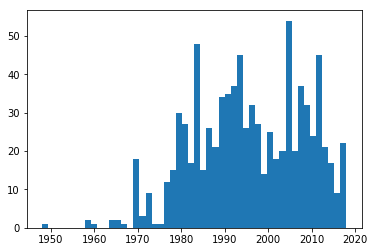

In [67]:
# Year information (All)
print('{} records have an associated year in the publication info (Plotted below)'.format(len(year_all_dict)))
plt.hist(year_all_dict.values(), bins=50)

650 records (excluding books) have an associated year in the publication info (Plotted below)


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  2.,
         1.,  0., 18.,  3.,  9.,  1.,  1., 11., 15., 23., 25., 14., 43.,
        13., 24., 16., 18., 25., 29., 39., 23., 30., 17., 10., 16., 15.,
        15., 34., 14., 22., 26., 17., 23., 16., 12.,  7., 18.]),
 array([1948. , 1949.4, 1950.8, 1952.2, 1953.6, 1955. , 1956.4, 1957.8,
        1959.2, 1960.6, 1962. , 1963.4, 1964.8, 1966.2, 1967.6, 1969. ,
        1970.4, 1971.8, 1973.2, 1974.6, 1976. , 1977.4, 1978.8, 1980.2,
        1981.6, 1983. , 1984.4, 1985.8, 1987.2, 1988.6, 1990. , 1991.4,
        1992.8, 1994.2, 1995.6, 1997. , 1998.4, 1999.8, 2001.2, 2002.6,
        2004. , 2005.4, 2006.8, 2008.2, 2009.6, 2011. , 2012.4, 2013.8,
        2015.2, 2016.6, 2018. ]),
 <a list of 50 Patch objects>)

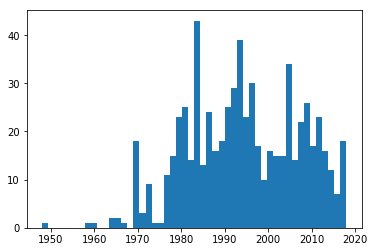

In [68]:
# Year information (No books)
print('{} records (excluding books) have an associated year in the publication info (Plotted below)'.format(len(year_nobook_dict)))
plt.hist(year_nobook_dict.values(), bins=50)

In [69]:
journal_df = pd.DataFrame(journal_list)
unique_journals = journal_df[0].value_counts()
print('{} records have a journal title, of which there are {} unique journals. Of which journals which appear the most are:'.format(len(journal_list), len(unique_journals)))
unique_journals[:20]

765 records have a journal title, of which there are 124 unique journals. Of which journals which appear the most are:


Nucl.Phys.A                                210
Phys.Lett.B                                 64
Nuovo Cim.A                                 27
Astrophys.J.                                26
Lect.Notes Phys.                            26
Phys.Rev.D                                  23
Nucl.Phys.B Proc.Suppl.                     21
Eur.Phys.J.C                                20
Int.J.Mod.Phys.A                            16
Nucl.Phys.B                                 15
Camb.Monogr.Part.Phys.Nucl.Phys.Cosmol.     13
Nucl.Instrum.Meth.A                         12
PoS                                         12
Front.Phys.                                 11
Riv.Nuovo Cim.                              10
Adv.Ser.Direct.High Energy Phys.            10
Eur.Phys.J.A                                 9
Springer Tracts Mod.Phys.                    9
Phys.Rev.Lett.                               8
AIP Conf.Proc.                               8
Name: 0, dtype: int64

# Please ignore after this

### Investiagte non-existent "cited" articles

In [26]:
non_overlapping = np.setdiff1d(np.union1d(records.oldRef.unique(), legacy.recID.unique()), np.intersect1d(records.oldRef.unique(), legacy.recID.unique()))
non_overlapping = non_overlapping[1:] # Remove entry for Zero

In [27]:
print('List from Legacy machine and from ES queries has {} non-overlapping records'.format(len(non_overlapping)))

List from Legacy machine and from ES queries has 5289 non-overlapping records


In [50]:
cited_in_dump_but_not_bibrank = []
cited_in_bibrank_but_not_dump = []
for article in non_overlapping:
    if len(records[records.oldRef == article]) != 0:
        cited_in_dump_but_not_bibrank.append(article)
    if len(legacy[legacy.recID == article]) != 0:
        cited_in_bibrank_but_not_dump.append(article)

In [100]:
cited_in_bibrank = legacy_indexed.loc[cited_in_bibrank_but_not_dump]

In [101]:
cited_in_dump = pd.DataFrame(records.oldRef.value_counts()[cited_in_dump_but_not_bibrank])
cited_in_dump.columns = ['Citation_Difference']

## Miscellaneous Stuff

##### Top 200 Citeable

In [70]:
g = citeable_articles_with_loss_ext.reindex(exist_list)
g = g[~g.Citation_Difference.isna()]

In [71]:
d = citeable_articles_with_loss_ext.Citation_Difference.value_counts()
sum(d[-6:])

2067

In [72]:
top_200_lost_citeable= g.iloc[:200].index

In [74]:
# PLEASE ONLY RUN ONCE
if 'top_200_citeable_df' in locals():
    del top_200_citeable_df

for rid in top_200_lost_citeable:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_citeable_df' in locals():
        top_200_citeable_df = top_200_citeable_df.append(one_of_the_200)
    else:
        top_200_citeable_df = one_of_the_200

In [75]:
top_200_citeable_df.to_csv('top_200_citeable_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [76]:
g.iloc[0:200].to_csv('top_200_citeable_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [77]:
g.iloc[:200]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,-1064.0,1611.0,547.0
299778,-1030.0,1478.0,448.0
181166,-912.0,1728.0,816.0
1390184,-855.0,866.0,11.0
87997,-771.0,967.0,196.0
794379,-445.0,508.0,63.0
279039,-383.0,821.0,438.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0


In [78]:
top_200_lost_citeable

Int64Index([  50008,  299778,  181166, 1390184,   87997,  794379,  279039,
             640063,  744400,  618647,
            ...
             809164,  809165,  809194,  809168,  809193,  809196,  809195,
             809235,  809225,  809226],
           dtype='int64', name='recID', length=200)

##### Top 200 Core

In [79]:
f = core_articles_with_loss_ext.reindex(exist_list)
f = f[~f.Citation_Difference.isna()]

In [80]:
c = core_articles_with_loss_ext.Citation_Difference.value_counts()
sum(c[-6:])

1790

In [81]:
top_200_lost_core= f.iloc[:200].index

In [82]:
# PLEASE ONLY RUN ONCE
if 'top_200_df' in locals():
    del top_200_df

for rid in top_200_lost_core:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_df' in locals():
        top_200_df = top_200_df.append(one_of_the_200)
    else:
        top_200_df = one_of_the_200

In [83]:
top_200_df.to_csv('top_200_core_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [84]:
f.iloc[0:200].to_csv('top_200_core_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [85]:
f.iloc[:200]

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1030.0,1478.0,448.0
181166,-912.0,1728.0,816.0
794379,-445.0,508.0,63.0
279039,-383.0,821.0,438.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0
706151,-322.0,338.0,16.0
618647,-310.0,330.0,20.0
345963,-304.0,316.0,12.0


In [86]:
top_200_lost_core

Int64Index([299778, 181166, 794379, 279039, 640063, 744400, 706151, 618647,
            345963, 656250,
            ...
            809228, 809229, 809230, 809231, 809232, 809233, 809234, 809237,
            809223, 809238],
           dtype='int64', name='recID', length=200)

##### Difference List

In [87]:
len(np.intersect1d(f[0:200].index, g[0:200].index))

173

In [88]:
different_between_core200_and_citeable200 = np.setxor1d(f[0:200].index, g[0:200].index)

In [89]:
diff_top_200 = lost_citations_ext.reindex(different_between_core200_and_citeable200)
diff_top_200 = diff_top_200[~diff_top_200.Citation_Difference.isna()]
diff_top_200.sort_values('Citation_Difference')

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,-1064.0,1611.0,547.0
1390184,-855.0,866.0,11.0
87997,-771.0,967.0,196.0
706151,-322.0,338.0,16.0
656250,-299.0,484.0,185.0
391003,-284.0,310.0,26.0
61163,-254.0,259.0,5.0
619666,-210.0,336.0,126.0
52528,-206.0,208.0,2.0


##### Top 200 Core and CIteable

In [90]:
top_200_core_and_citeable = np.intersect1d(f.index, g.index)

In [91]:
top_200 = lost_citations_ext.reindex(top_200_core_and_citeable)
top_200 = top_200[~top_200.Citation_Difference.isna()]
top_200 = top_200.sort_values('Citation_Difference')

In [92]:
top_200 = top_200[0:200]

In [93]:
top_200_lost = top_200.index

In [94]:
# PLEASE ONLY RUN ONCE
if 'top_200_all_df' in locals():
    del top_200_all_df

for rid in top_200_lost:
    one_of_the_200 = records[(records.oldRef == rid) | (records.newRef == rid)]
    
    if 'top_200_all_df' in locals():
        top_200_all_df = top_200_all_df.append(one_of_the_200)
    else:
        top_200_all_df = one_of_the_200

In [95]:
top_200_all_df.to_csv('top_200_core_citeable_lost_citation_records-NEWAUG2018-curated_corrected.csv')

In [96]:
top_200.to_csv('top_200_core_citeable_lost_citations_recids-NEWAUG2018-curated_corrected.csv')

In [97]:
top_200

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
299778,-1030.0,1478.0,448.0
181166,-912.0,1728.0,816.0
794379,-445.0,508.0,63.0
279039,-383.0,821.0,438.0
640063,-350.0,412.0,62.0
744400,-342.0,342.0,0.0
618647,-310.0,330.0,20.0
345963,-304.0,316.0,12.0
338625,-299.0,299.0,0.0


In [98]:
top_200_all_df

,recID,oldRef,newRef,metaData
580716,413402,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '23', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['New York']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
638861,407131,299778,299778,"{'legacy_curated': True, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': True}"
1038102,486892,299778,299778,"{'legacy_curated': True, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': True}"
1039087,486744,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '1', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Redwood City, CA,)']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1146764,498550,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'misc': ['The early universe Publishing Company']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1188663,554327,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '26', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Frontiers in Physics, Vol. 69 Redwood']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1193971,543013,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'label': '3', 'publication_info': {'year': 1990}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'title': {'title': 'The Early universe'}, 'misc': ['Reading, MA']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1218232,541767,299778,0,"{'reference': {'authors': [{'full_name': 'Kolb, E.'}, {'full_name': 'Turner, M.'}], 'misc': ['(Adison-Wesley, New York)'], 'title': {'title': 'The Early universe'}, 'label': '11', 'publication_info': {'year': 1990}}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1376988,573966,299778,0,"{'reference': {'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.'}], 'label': '97', 'misc': ['The Early Universe (Perseus book 1994)']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"
1394926,576374,299778,0,"{'reference': {'imprint': {'publisher': 'Addison-Wesley'}, 'authors': [{'full_name': 'Kolb, E.W.'}, {'full_name': 'Turner, M.S.'}], 'label': '5', 'misc': ['1990, The Early Universe (Reading ) p 38, p84']}, 'recid': 299778, 'record': {'$ref': 'http://localhost:5000/api/literature/299778'}, 'curated_relation': False}"


### Take out curated relations

In [250]:
from ast import literal_eval as le

In [251]:
unmatched_records = records[records.oldRef != records.newRef]
df = pd.DataFrame()

In [252]:
%%time

for i in range(len(unmatched_records)):
    record = unmatched_records[i:i+1]
    if le(record.metaData[record.index[0]]).get('curated_relation') is True:
        record.newRef = le(record.metaData[record.index[0]])['recid']
    df = df.append(record)

print()

/home/salman/python3venv/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



CPU times: user 1h 15min 50s, sys: 0 ns, total: 1h 15min 50s
Wall time: 1h 15min 53s


In [278]:
# Get the updated references
df[df.oldRef == df.newRef]

,recID,oldRef,newRef,metaData
4849,437543,430946,430946,"{'legacy_curated': True, 'recid': 430946, 'record': {'$ref': 'http://localhost:5000/api/literature/430946'}, 'curated_relation': True}"
4850,437543,431289,431289,"{'reference': {'label': '4'}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/431289'}, 'recid': 431289, 'curated_relation': True}"
4911,437723,236472,236472,"{'reference': {'misc': ['Snowmass, Proc. SSC Summer Study,, p. 384'], 'authors': [{'full_name': 'Peck, S.'}], 'label': '8', 'publication_info': {'year': 1984}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/236472'}, 'recid': 236472, 'curated_relation': True}"
23939,433632,369463,369463,"{'reference': {'label': '143'}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369463'}, 'recid': 369463, 'curated_relation': True}"
25646,434070,369240,369240,"{'reference': {'authors': [{'full_name': 'Lutz, P.'}], 'title': {'title': 'SUSY with DELPHI'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369240'}, 'recid': 369240, 'curated_relation': True}"
25647,434070,369242,369242,"{'reference': {'authors': [{'full_name': 'Brown, R.'}], 'title': {'title': 'Searches for New Paricles in OPAL'}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/369242'}, 'recid': 369242, 'curated_relation': True}"
27278,434775,197970,197970,"{'legacy_curated': True, 'recid': 197970, 'record': {'$ref': 'http://localhost:5000/api/literature/197970'}, 'curated_relation': True}"
41540,393962,430946,430946,"{'legacy_curated': True, 'recid': 430946, 'record': {'$ref': 'http://localhost:5000/api/literature/430946'}, 'curated_relation': True}"
44467,399336,382504,382504,"{'legacy_curated': True, 'recid': 382504, 'record': {'$ref': 'http://localhost:5000/api/literature/382504'}, 'curated_relation': True}"
53404,410648,408588,408588,"{'reference': {'authors': [{'full_name': 'T.K.Gaisser'}, {'full_name': 'M.Honda'}, {'full_name': 'K.Kasahara'}, {'full_name': 'H.Lee'}, {'full_name': 'S.Midorikawa'}, {'full_name': 'V.Naumov'}], 'misc': ['and Todor Stanev Proceedings of the 24th lCRC. vol. 1. 702'], 'title': {'title': 'Comparison of Neutrino Flux calculations'}, 'label': '19', 'publication_info': {'year': 1995}}, 'legacy_curated': True, 'record': {'$ref': 'http://localhost:5000/api/literature/408588'}, 'recid': 408588, 'curated_relation': True}"


In [283]:
records.iloc[df.index] = df

In [285]:
records.to_csv('new-citations-NEWAUG2018-corrected_for_curated-references.tsv', sep='\t')

In [288]:
c = records.newRef.value_counts()

In [292]:
c = c[1:]

In [295]:
c = c.sort_index()

In [296]:
c.to_csv('new-citation-counts-NEWAUG2018-corrected_for_curated_references.tsv', sep='\t')

In [99]:
lost_citations_ext

,Citation_Difference,Legacy_Count,Labs_Count
recID,,,
50008,-1064.0,1611.0,547.0
299778,-1030.0,1478.0,448.0
181166,-912.0,1728.0,816.0
1390184,-855.0,866.0,11.0
87997,-771.0,967.0,196.0
794379,-445.0,508.0,63.0
279039,-383.0,821.0,438.0
673262,-366.0,429.0,63.0
640063,-350.0,412.0,62.0
